In [2]:
!pip install numpy --upgrade





     ---------------------------------------- 0.0/61.2 kB ? eta -:--:--
     ---------------------------------------- 61.2/61.2 kB 3.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/15.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/15.8 MB 1.6 MB/s eta 0:00:10
   ---------------------------------------- 0.2/15.8 MB 2.4 MB/s eta 0:00:07
    --------------------------------------- 0.4/15.8 MB 2.8 MB/s eta 0:00:06
   - -------------------------------------- 0.6/15.8 MB 3.5 MB/s eta 0:00:05
   -- ------------------------------------- 0.9/15.8 MB 4.0 MB/s eta 0:00:04
   -- ------------------------------------- 1.1/15.8 MB 4.2 MB/s eta 0:00:04
   --- ------------------------------------ 1.5/15.8 MB 4.6 MB/s eta 0:00:04
   ---- ----------------------------------- 1.8/15.8 MB 4.7 MB/s eta 0:00:03
   ----- ---------------------------------- 2.1/15.8 MB 4.9 MB/s eta 0:00:03
   ------ --------------------------------- 2.4/15.8 MB 5.0 MB/s eta 0:00:03
   -----

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
transformers 2.1.1 requires sentencepiece, which is not installed.
numba 0.57.0 requires numpy<1.25,>=1.21, but you have numpy 1.26.2 which is incompatible.


In [1]:
import random
import os
import glob as gl
import time 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Dropout,  Flatten, Dense,MaxPool2D

from tensorflow.keras import layers,Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,precision_recall_fscore_support
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from scikitplot.metrics import plot_roc
from keras.callbacks import EarlyStopping

# GridSearchCV ou RandomizedSearchCV pour l'optimisation des hyperparamètres
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold




import warnings 
warnings.filterwarnings("ignore")
%matplotlib inline
from scikeras.wrappers import KerasClassifier

# Dataset Exploration and Preprocessing

In [2]:

es = EarlyStopping(monitor='val_loss', patience=5, verbose=1,min_delta=0.0001)

##  Download and explore the datasetUnderstand the structure of the datas

In [3]:
train_dir="train/"
test_dir="test/"
os.listdir(train_dir)
os.listdir(test_dir)

['COVID19', 'NORMAL', 'PNEUMONIA']

In [4]:
class CFG:
    EPOCHS=10
    BATCH_SIZE=32
    SEED=42
    TF_SEED=768
    HEIGHT=224
    WIDTH=224
    CANNELS=3
    IMAGE_SIZE=(224,224,3)

In [5]:
# Fetching Paths of Training and Testing JPG Images in Subdirectories
train_images= gl.glob(f'{train_dir}**/*.jpg')
test_images= gl.glob(f'{test_dir}**/*.jpg')

In [6]:
#get train and test size
train_size=len(train_images)
test_size=len(test_images)
#get dataset size
print("Train Image size is :{}".format(train_size))
print("Test Image size is :{}".format(test_size))
total=train_size+test_size
print(f'Total:{total}')

Train Image size is :5144
Test Image size is :1288
Total:6432


## file formats, labels, metadata

In [7]:
# Création d'un dictionnaire de mapping
label_mapping = {'NORMAL': 0, 'PNEUMONIA': 1, 'COVID19': 2}

# Fonction pour mapper les étiquettes aux codes
def map_labels(label):
    return label_mapping.get(label)




In [8]:
def generate_labels(image_paths):
    labels = []
    for path in image_paths:
        parts = path.split('\\')
        label = parts[-2]
        label_code = map_labels(label)  # Utilisation de la fonction de mapping
        labels.append(label)
    return labels


In [9]:
# Fonction pour créer le DataFrame
def build_df(image_paths, labels):
    label_encoded = [map_labels(label) for label in labels]  # Encodage des étiquettes en valeurs numériques
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': labels,
        'label_encoded': label_encoded
    })
    return df.sample(frac=1, random_state=CFG.SEED).reset_index(drop=True) 

In [10]:
train_labels = generate_labels(train_images)
test_labels = generate_labels(test_images)

In [11]:
#Build the DataFrame
train_df=build_df(train_images, train_labels)
test_df=build_df(test_images,test_labels)

In [12]:
train_df['label'].value_counts()

PNEUMONIA    3418
NORMAL       1266
COVID19       460
Name: label, dtype: int64

In [13]:
#View first 5 samples in the training set
train_df.head(20)

,image_path,label,label_encoded
0,train\PNEUMONIA\PNEUMONIA(829).jpg,PNEUMONIA,1
1,train\PNEUMONIA\PNEUMONIA(2424).jpg,PNEUMONIA,1
2,train\PNEUMONIA\PNEUMONIA(1452).jpg,PNEUMONIA,1
3,train\PNEUMONIA\PNEUMONIA(52).jpg,PNEUMONIA,1
4,train\NORMAL\NORMAL(1147).jpg,NORMAL,0
5,train\NORMAL\NORMAL(539).jpg,NORMAL,0
6,train\PNEUMONIA\PNEUMONIA(3409).jpg,PNEUMONIA,1
7,train\NORMAL\NORMAL(123).jpg,NORMAL,0
8,train\PNEUMONIA\PNEUMONIA(1213).jpg,PNEUMONIA,1
9,train\PNEUMONIA\PNEUMONIA(976).jpg,PNEUMONIA,1


## Perform basic image preprocessing : resizing, normalization

In [14]:
def _load(image_path):
    #Read and decode and image file to uint8 tensor
    image=tf.io.read_file(image_path)
    image=tf.io.decode_jpeg(image,channels=3)
    
    #resize image
    image=tf.image.resize(image,[CFG.HEIGHT,CFG.WIDTH],method=tf.image.ResizeMethod.LANCZOS3)
    
    #convert image dtype to float32 and Normalize
    image=tf.cast(image,tf.float32)/255
    #Return image
    return image

## Split the dataset into training and testing sets.

In [15]:
# create Train/test split with training set
train_split_idx, val_split_idx, _, _ = train_test_split(
    train_df.index,
    train_df.label_encoded,
    test_size=0.5,
    stratify=train_df.label_encoded,
    random_state=CFG.SEED
)

# Chargement et transformation des images pour l'ensemble d'entraînement
train_images = []
train_labels = []
for idx in train_split_idx:
    image_path = train_df.loc[idx, 'image_path']
    image = _load(image_path)
    train_images.append(image)
    label = train_df.loc[idx, 'label_encoded']
    train_labels.append(label)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Chargement et transformation des images pour l'ensemble de validation
val_images = []
val_labels = []
for idx in val_split_idx:
    image_path = train_df.loc[idx, 'image_path']
    image = _load(image_path)
    val_images.append(image)
    label = train_df.loc[idx, 'label_encoded']
    val_labels.append(label)

val_images = np.array(val_images)
val_labels = np.array(val_labels)


## Nature du Problème :
- Les réseaux de neurones convolutionnels (CNN) sont couramment utilisés pour la classification d'images en raison de leur capacité à extraire des caractéristiques spatiales. Si votre tâche implique la classification d'images (comme dans la détection de pneumonie à partir de rayons X), les CNN sont adaptés pour apprendre les motifs visuels complexes.

## Architecture CNN :
- L'architecture spécifiée comprend des couches convolutives, de pooling, de dropout et des couches entièrement connectées, ce qui permet au modèle d'apprendre des hiérarchies de caractéristiques à différentes échelles. Les couches de dropout aident à régulariser le modèle pour réduire le surajustement.

## Nombre de Couches et Filtres :
- Le modèle commence avec des couches moins profondes (64 filtres) et augmente progressivement le nombre de filtres (jusqu'à 512) pour capturer des caractéristiques de plus en plus abstraites. Cela permet une représentation hiérarchique des données.

## Ressources Disponibles :
- La complexité du modèle (nombre de couches, de filtres, etc.) est adaptée aux ressources disponibles nous avons 2572 . Cette architecture peut être modifiée en fonction de la taille de l'ensemble de données et des capacités matérielles pour assurer un apprentissage efficace.

In [16]:
model = Sequential()
model.add(Conv2D(64,(3,3),activation = "relu", input_shape = CFG.IMAGE_SIZE))
model.add(MaxPool2D())

model.add(Conv2D( 128, (3,3), activation = "relu"))
model.add(MaxPool2D())
model.add(Dropout(0.2))

model.add(Conv2D( 256,(3,3), activation = "relu"))
model.add(MaxPool2D())
model.add(Dropout(0.2))

model.add(Conv2D( 512,(3,3), activation = "relu"))
model.add(MaxPool2D())
model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.15))

model.add(Dense(3, activation = "softmax"))

# Compilez le modèle avec sparse_categorical_crossentropy
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 128)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 54, 54, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 256)      

## Model Implementation and Training

In [17]:
import numpy as np

# Calculer les poids inverses des fréquences des classes
total_samples = len(train_labels)
class_weights = {
    0: total_samples / (3 * np.bincount(train_labels)[0]),
    1: total_samples / (3 * np.bincount(train_labels)[1]),
    2: total_samples / (3 * np.bincount(train_labels)[2]),
}

import numpy as np

# Calculer les poids inverses des fréquences des classes
total_samples = len(val_labels)
class_weights = {
    0: total_samples / (3 * np.bincount(val_labels)[0]),
    1: total_samples / (3 * np.bincount(val_labels)[1]),
    2: total_samples / (3 * np.bincount(val_labels)[2]),
}



In [ ]:
# Entraînement du modèle
history = model.fit(train_images, train_labels,
                    CFG.EPOCHS,
                    CFG.BATCH_SIZE,
                    validation_data=(val_images, val_labels),
                    callbacks=[es])

Epoch 1/128

127/258 [=============>................] - ETA: 2:58 - loss: 0.8134 - accuracy: 0.7197

##  monitor performance.

In [117]:
print("training_accuracy", history.history['accuracy'][-1])
print("validation_accuracy", history.history['val_accuracy'][-1])

training_accuracy 0.9716174006462097
validation_accuracy 0.9416796565055847


<Axes: >

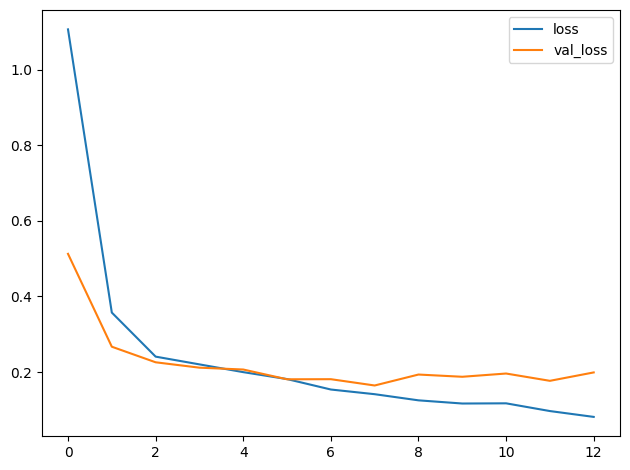

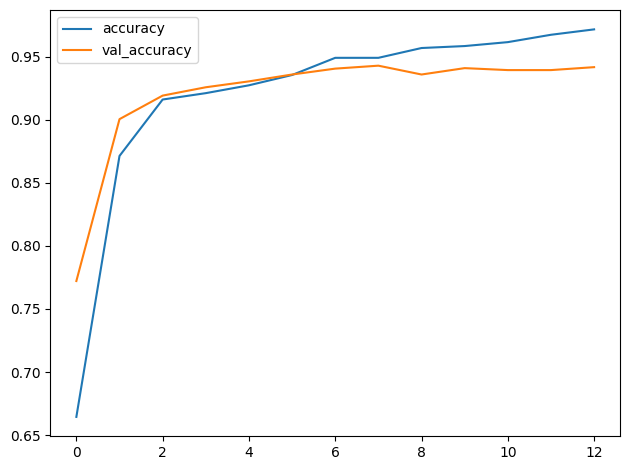

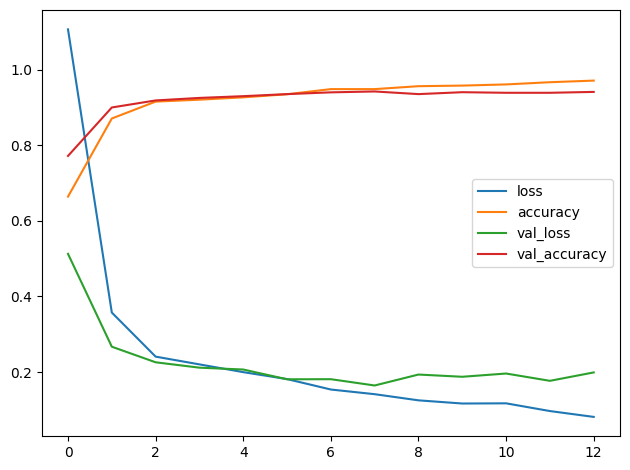

In [118]:
losses = pd.DataFrame(history.history)
losses.head()
losses[['loss','val_loss']].plot() 
losses[['accuracy','val_accuracy']].plot() 
losses.plot()

## Hyperparameter Tuning: Adjust learning rate, batch size, and other hyperparameters

In [ ]:




learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64, 128]
epochs = 10
base_model = model 

results = {}

for lr in learning_rates:
    for bs in batch_sizes:
        model = base_model

        # Compile the model
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
        model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Fit the model
        history = model.fit(train_images, train_labels, epochs=epochs, batch_size=bs, verbose=0,
                            validation_data=(val_images, val_labels))

        # Evaluate the model on test set and store the results
        score = model.evaluate(X_test, y_test, verbose=0)
        results[(lr, bs)] = score
        




In [ ]:

# Affichage des performances pour chaque combinaison d'hyperparamètres
for params, score in results.items():
    print("Learning rate: {}, Batch size: {}, Test accuracy: {}".format(params[0], params[1], score[1]))

## Monitor the effect on model convergence and performance

In [ ]:
losses = pd.DataFrame(history.history)
losses.head()
losses[['loss','val_loss']].plot() 
losses[['accuracy','val_accuracy']].plot() 
losses.plot()


## Evaluation Metrics and Analysis: Choose appropriate evaluation metrics (e.g., accuracy, precision, recall, F1-score) + Evaluate the model on the test set and provide a detailed analysis of results.

In [ ]:
# Prétraitement des images de test
test_images = []
for image_path in test_df['image_path']:
    processed_image = _load(image_path)
    test_images.append(processed_image)

# Conversion en tableau numpy
test_images = np.array(test_images)

# Obtention des étiquettes de test depuis test_df
test_labels = test_df['label_encoded'].values


In [ ]:
#Évaluation du modèle avec les données de test
evaluation = model.evaluate(test_images, test_labels)
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

# Prédiction des étiquettes pour les données de test
y_pred = model.predict(test_images)
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

# Obtention des étiquettes réelles
y_true = test_labels  

# Création de la matrice de confusion
CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index=classes)

# Tracé de la matrice de confusion
plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot=True, fmt='g', vmin=0, vmax=250, cmap='Blues')
ax.set_xlabel('Predicted', fontsize=14, weight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

ax.set_ylabel('Actual', fontsize=14, weight='bold')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_title('Confusion Matrix - Test Set', fontsize=16, weight='bold', pad=20)


In [ ]:
print(classification_report(y_true, predictions))

## Data Augmentation

In [83]:
model = Sequential()
model.add(Conv2D(64,(3,3),activation = "relu", input_shape = CFG.IMAGE_SIZE))
model.add(MaxPool2D())

model.add(Conv2D( 128, (3,3), activation = "relu"))
model.add(MaxPool2D())
model.add(Dropout(0.2))

model.add(Conv2D( 256,(3,3), activation = "relu"))
model.add(MaxPool2D())
model.add(Dropout(0.2))

model.add(Conv2D( 512,(3,3), activation = "relu"))
model.add(MaxPool2D())
model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.15))

model.add(Dense(3, activation = "softmax"))

# Compilez le modèle avec sparse_categorical_crossentropy
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 111, 111, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 54, 54, 128)       0         
 ng2D)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 54, 54, 128)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 52, 52, 256)      

In [84]:
# Générateur d'entraînement
train_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    rescale=1./255
).flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='sparse',  # Utiliser 'sparse' pour les noms de classe
    subset='training',
    shuffle=True,
    seed=42
)

# Générateur de validation
validation_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    rescale=1./255
).flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='sparse',  # Utiliser 'sparse' pour les noms de classe
    subset='validation',
    shuffle=True,
    seed=42
)

# Générateur de test
test_generator = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='sparse',  # Utiliser 'sparse' pour les noms de classe
    shuffle=False
)


Found 4116 images belonging to 3 classes.
Found 1028 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [93]:
# Calculer les poids inverses des fréquences des classes pour les données d'entraînement
total_train_samples = len(train_generator.labels)
class_weights_train = {
    0: total_train_samples / (3 * np.bincount(train_generator.labels)[0]),
    1: total_train_samples / (3 * np.bincount(train_generator.labels)[1]),
    2: total_train_samples / (3 * np.bincount(train_generator.labels)[2]),
}

# Calculer les poids inverses des fréquences des classes pour les données de validation
total_val_samples = len(validation_generator.labels)
class_weights_val = {
    0: total_val_samples / (3 * np.bincount(validation_generator.labels)[0]),
    1: total_val_samples / (3 * np.bincount(validation_generator.labels)[1]),
    2: total_val_samples / (3 * np.bincount(validation_generator.labels)[2]),
}

# Calculer les poids inverses des fréquences des classes pour les données de test
total_test_samples = len(test_generator.labels)
class_weights_test = {
    0: total_test_samples / (3 * np.bincount(test_generator.labels)[0]),
    1: total_test_samples / (3 * np.bincount(test_generator.labels)[1]),
    2: total_test_samples / (3 * np.bincount(test_generator.labels)[2]),
}


## Re-train the model with the augmented dataset

In [85]:
# Entraînez votre modèle avec les générateurs de données
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=CFG.EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[es]
)


Epoch 1/10
33/33 [==============================] - 614s 18s/step - loss: 1.7358 - accuracy: 0.6018 - val_loss: 0.9206 - val_accuracy: 0.6644
Epoch 2/10
33/33 [==============================] - 601s 18s/step - loss: 0.7100 - accuracy: 0.6963 - val_loss: 0.5764 - val_accuracy: 0.7461
Epoch 3/10
33/33 [==============================] - 597s 18s/step - loss: 0.4878 - accuracy: 0.8008 - val_loss: 0.4450 - val_accuracy: 0.8259
Epoch 4/10
33/33 [==============================] - 589s 18s/step - loss: 0.4186 - accuracy: 0.8277 - val_loss: 0.4476 - val_accuracy: 0.8220
Epoch 5/10
33/33 [==============================] - 580s 17s/step - loss: 0.3544 - accuracy: 0.8588 - val_loss: 0.3884 - val_accuracy: 0.8580
Epoch 6/10
33/33 [==============================] - 1271s 18s/step - loss: 0.3409 - accuracy: 0.8601 - val_loss: 0.3757 - val_accuracy: 0.8638
Epoch 7/10
33/33 [==============================] - 591s 18s/step - loss: 0.3274 - accuracy: 0.8768 - val_loss: 0.4029 - val_accuracy: 0.8648
Epoch

## evaluate its impact on performance

In [86]:
# Évaluation du modèle sur les données de test
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


11/11 [==============================] - 57s 5s/step - loss: 0.2588 - accuracy: 0.9053
Test Loss: 0.25876298546791077
Test Accuracy: 0.9052795171737671


11/11 [==============================] - 86s 7s/step


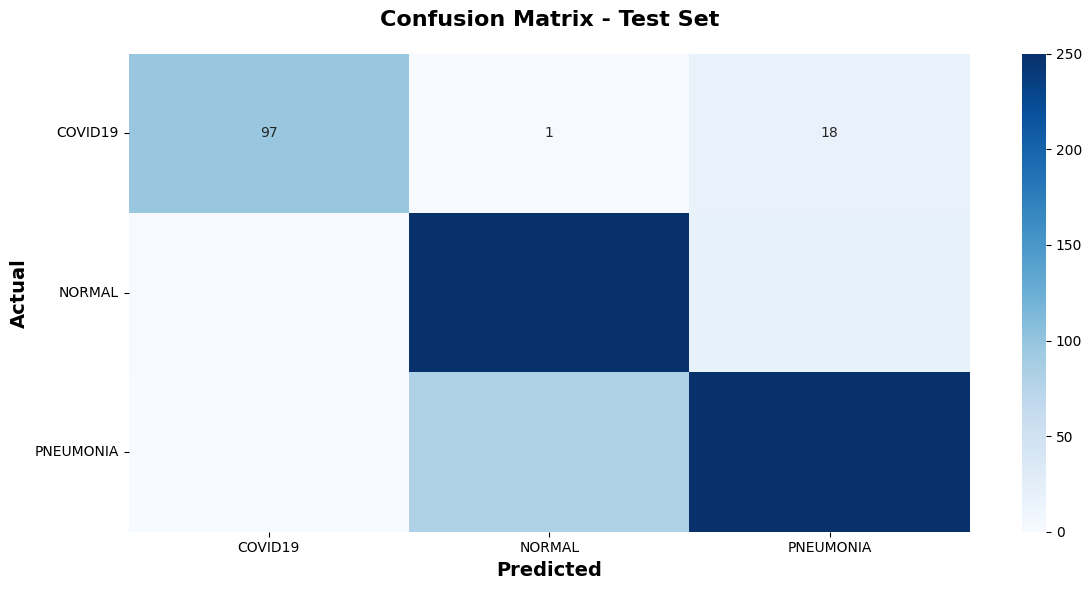

In [91]:



classes = ["COVID19", "NORMAL", "PNEUMONIA"]

y_pred = model.predict(test_generator)
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_generator.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [89]:
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

           0       0.99      0.84      0.91       116
           1       0.78      0.93      0.85       317
           2       0.95      0.90      0.93       855

    accuracy                           0.91      1288
   macro avg       0.91      0.89      0.90      1288
weighted avg       0.91      0.91      0.91      1288



<Axes: >

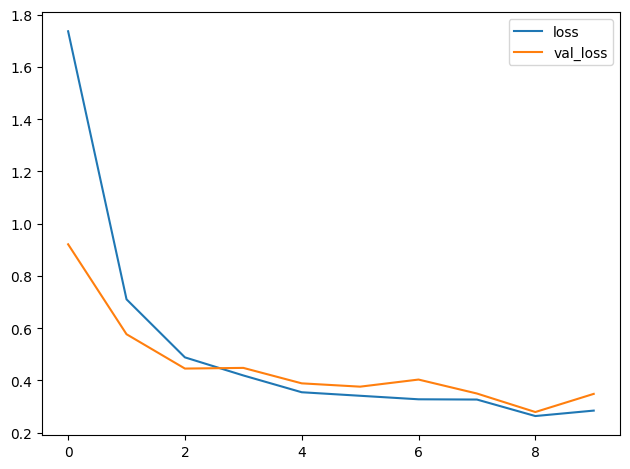

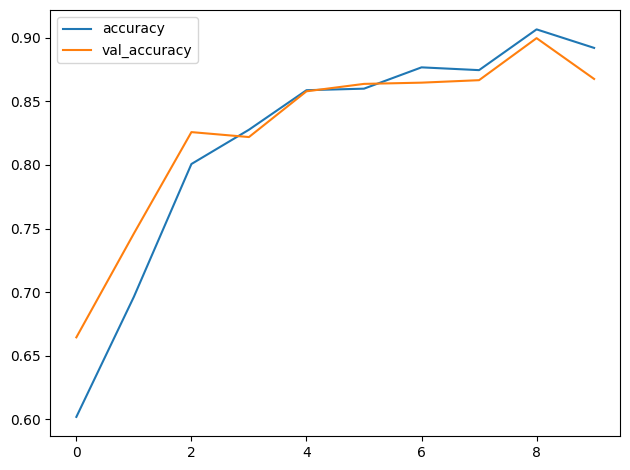

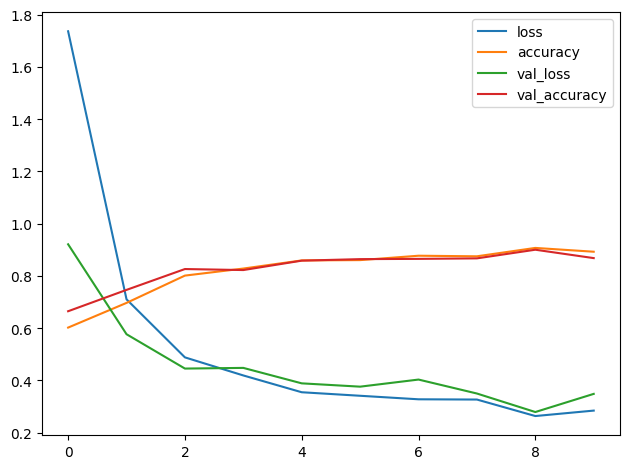

In [87]:
losses = pd.DataFrame(history.history)
losses.head()
losses[['loss','val_loss']].plot() 
losses[['accuracy','val_accuracy']].plot() 
losses.plot()


## Transfer leaning

In [75]:
from tensorflow import keras
from keras import preprocessing
# Define the base model for transfer learning
base_model = keras.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Freeze the weights of the base model so that they are not updated during training
for layer in base_model.layers:
    layer.trainable = False

# Create a new model by adding a classification head on top of the base model
model = keras.models.Sequential()
model.add(base_model)
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(3, activation='softmax'))

# Compile the model with the Adam optimizer and categorical cross-entropy loss function
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 256)               524544    
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 3)                 771       
                                                                 
Total params: 24090115 (91.90 MB)
Trainable params: 525315 (2.00 MB)
Non-trainable params: 23564800 (89.89 MB)
_________

In [76]:

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

Epoch 1/10
33/33 [==============================] - 573s 17s/step - loss: 0.4939 - accuracy: 0.8202 - val_loss: 0.2304 - val_accuracy: 0.9163
Epoch 2/10
33/33 [==============================] - 464s 14s/step - loss: 0.2284 - accuracy: 0.9135 - val_loss: 0.2098 - val_accuracy: 0.9290
Epoch 3/10
33/33 [==============================] - 576s 17s/step - loss: 0.2036 - accuracy: 0.9218 - val_loss: 0.1828 - val_accuracy: 0.9358
Epoch 4/10
33/33 [==============================] - 531s 16s/step - loss: 0.1835 - accuracy: 0.9300 - val_loss: 0.1570 - val_accuracy: 0.9446
Epoch 5/10
33/33 [==============================] - 535s 16s/step - loss: 0.1659 - accuracy: 0.9419 - val_loss: 0.1855 - val_accuracy: 0.9368
Epoch 6/10
33/33 [==============================] - 570s 17s/step - loss: 0.1595 - accuracy: 0.9414 - val_loss: 0.1667 - val_accuracy: 0.9465
Epoch 7/10
33/33 [==============================] - 447s 13s/step - loss: 0.1658 - accuracy: 0.9385 - val_loss: 0.1759 - val_accuracy: 0.9416
Epoch 

In [77]:
print("training_accuracy", history.history['accuracy'][-1])
print("validation_accuracy", history.history['val_accuracy'][-1])

training_accuracy 0.9424198269844055
validation_accuracy 0.9474708437919617


<Axes: >

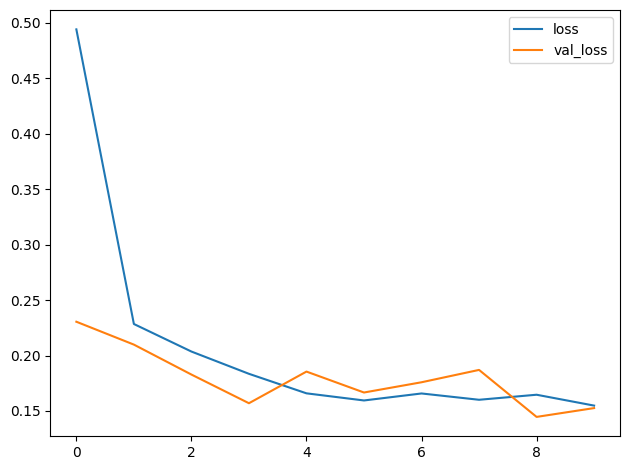

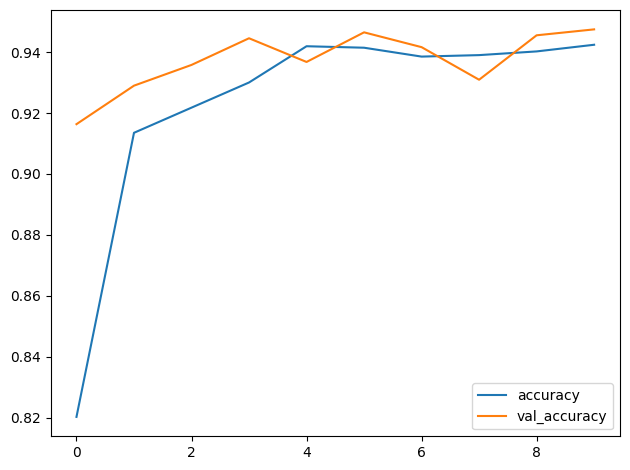

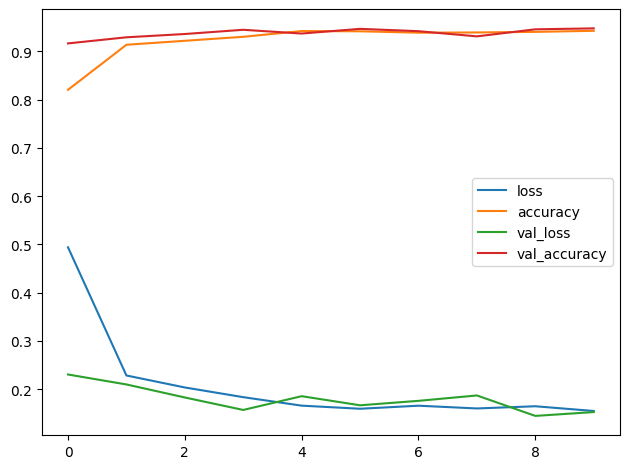

In [78]:
losses = pd.DataFrame(history.history)
losses.head()
losses[['loss','val_loss']].plot() 
losses[['accuracy','val_accuracy']].plot() 
losses.plot()

11/11 [==============================] - 75s 6s/step


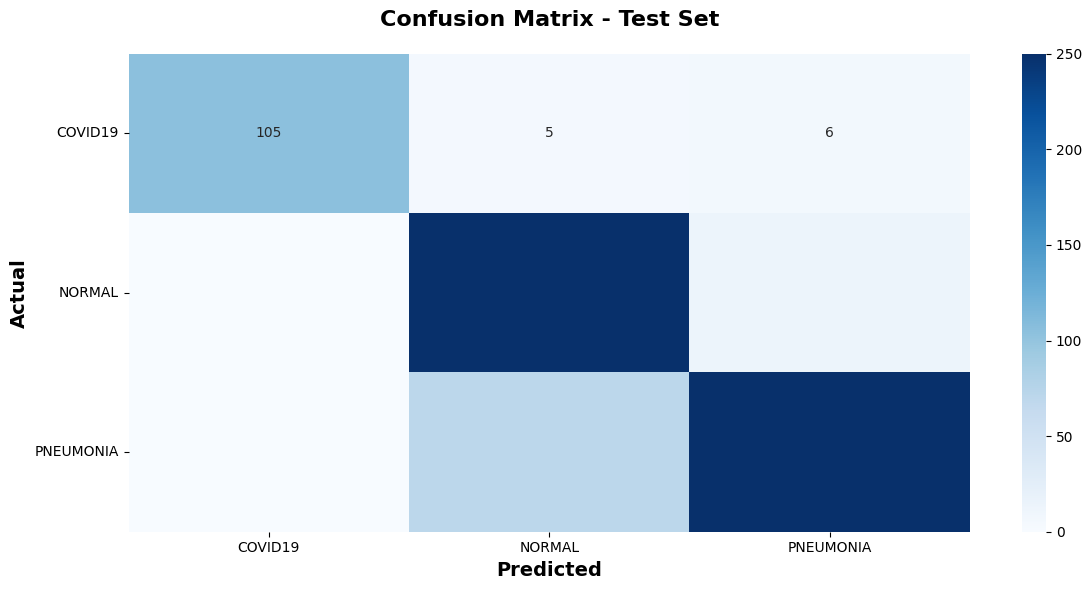

In [79]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


classes = ["COVID19", "NORMAL", "PNEUMONIA"]

y_pred = model.predict(test_generator)
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_generator.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [80]:
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95       116
           1       0.80      0.96      0.87       317
           2       0.98      0.92      0.95       855

    accuracy                           0.93      1288
   macro avg       0.92      0.93      0.92      1288
weighted avg       0.93      0.93      0.93      1288



In [81]:
filenames=test_generator.filenames
predicted_classes = np.argmax(y_pred, axis=1)
class_names = test_generator.class_indices
class_names = {v: k for k, v in class_names.items()}
predicted_class_names = [class_names[k] for k in predicted_classes]

# Create a dataframe to store the results
results_df = pd.DataFrame({'filename': filenames, 'predicted_class': predicted_class_names})

# Add a column for the actual class
results_df['actual_class'] = results_df['filename'].apply(lambda x: os.path.dirname(x))

# Add a column for the image name
results_df['image_name'] = results_df['filename'].apply(lambda x: os.path.basename(x))

# Add a column for the image source folder name
results_df['folder_name'] = results_df['filename'].apply(lambda x: os.path.basename(os.path.dirname(x)))

# Reorder the columns
results_df = results_df[['image_name', 'folder_name', 'actual_class', 'predicted_class']]

# Save the results to a CSV file
results_df.to_csv('results.csv', index=False)

In [82]:
print(results_df)

               image_name folder_name actual_class predicted_class
0        COVID19(460).jpg     COVID19      COVID19         COVID19
1        COVID19(461).jpg     COVID19      COVID19         COVID19
2        COVID19(462).jpg     COVID19      COVID19         COVID19
3        COVID19(463).jpg     COVID19      COVID19         COVID19
4        COVID19(464).jpg     COVID19      COVID19         COVID19
...                   ...         ...          ...             ...
1283  PNEUMONIA(4268).jpg   PNEUMONIA    PNEUMONIA       PNEUMONIA
1284  PNEUMONIA(4269).jpg   PNEUMONIA    PNEUMONIA       PNEUMONIA
1285  PNEUMONIA(4270).jpg   PNEUMONIA    PNEUMONIA       PNEUMONIA
1286  PNEUMONIA(4271).jpg   PNEUMONIA    PNEUMONIA       PNEUMONIA
1287  PNEUMONIA(4272).jpg   PNEUMONIA    PNEUMONIA       PNEUMONIA

[1288 rows x 4 columns]
